## Traveling salesman problem  using simulated annealing MC

Small project on solving (or approximating the solution) the traveling salesman problem using the simulated annealing Monte Carlo technique. The salesman has to visit the 10 largest cities in the US, ranked here by population and coordinates in degrees (Wikipedia):

New York          40.6635 N , 73.9387 W

Los Angeles       34.0194 N , 118.4108 W

Chicago           41.8376 N , 87.6618 W

Houston           29.7866 N , 95.3909 W

Phoenix           33.5722 N , 112.0901 W

Philadelphia      40.0094 N , 75.1333 W

San Antonio       29.4724 N , 98.7665 W

San Diego         32.8153 N , 117.1350 W

Dallas            32.7933 N , 96.7665 W

San Jose          37.2967 N , 121.8189 W

The distances between cities will be calculated on a flat 2D grid where the longitude and latitude will serve as the traditional x- and y-axes. One degree is about 69 miles.  

The distances between each city will be stored in an 10x10 array, and the total distance traveled will be minimized using the simulated annealing technique by lowering the "temperature" in a sawtooth- like fashion with the standard Metropolis algorithm.

In [1]:
# Import dependencies 
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cities = {'NY' : np.array([73.9387, 40.6635]),
          'LA' : np.array([118.4180, 34.0194]),
          'Chicago' : np.array([87.6618, 41.8376]),
          'Houston' : np.array([95.3909, 29.7866]),
          'Phoenix' : np.array([112.0901, 33.5722]),
          'Philadelphia' : np.array([75.1333, 40.0094]),
          'San_Antonio' : np.array([98.5251, 29.4724]),
          'San_Diego' : np.array([117.1350, 32.8153]),
          'Dallas' : np.array([96.7665, 32.7933]),
          'San_Jose' : np.array([121.8189, 37.2967]),
}

df = pd.DataFrame(columns=list(cities.keys()), index=list(cities.keys()))
for i in cities:
    for j in cities:
        df[i].loc[j] = np.linalg.norm(cities[i]-cities[j])
print(df)

                   NY       LA  Chicago  Houston  Phoenix Philadelphia  \
NY                  0  44.9728  13.7732  24.0521  38.8048      1.36195   
LA            44.9728        0  31.7343  23.4129  6.34368      43.6972   
Chicago       13.7732  31.7343        0  14.3166  25.7887      12.6612   
Houston       24.0521  23.4129  14.3166        0  17.1229      22.6909   
Phoenix       38.8048  6.34368  25.7887  17.1229        0      37.5132   
Philadelphia  1.36195  43.6972  12.6612  22.6909  37.5132            0   
San_Antonio   27.0135  20.4059  16.4593  3.14991   14.171      25.6555   
San_Diego     43.9035  1.75953  30.8232   21.954  5.10136      42.6134   
Dallas        24.1464  21.6862  12.8334  3.30644  15.3434       22.805   
San_Jose      47.9984  4.72301  34.4576  27.4744  10.4174      46.7643   

             San_Antonio San_Diego   Dallas San_Jose  
NY               27.0135   43.9035  24.1464  47.9984  
LA               20.4059   1.75953  21.6862  4.72301  
Chicago          16.

In [3]:
# Store the coordinates in a dictionary, lognitude first in order to follow the standard (x,y)-coordinate notation
cities = {'NY' : np.array([73.9387, 40.6635]),
          'LA' : np.array([118.4180, 34.0194]),
          'Chicago' : np.array([87.6618, 41.8376]),
          'Houston' : np.array([95.3909, 29.7866]),
          'Phoenix' : np.array([112.0901, 33.5722]),
          'Philadelphia' : np.array([75.1333, 40.0094]),
          'San_Antonio' : np.array([98.5251, 29.4724]),
          'San_Diego' : np.array([117.1350, 32.8153]),
          'Dallas' : np.array([96.7665, 32.7933]),
          'San_Jose' : np.array([121.8189, 37.2967]),
}

In [4]:
# Class for minimizing the path
class MC_TSM:
    
    # Constructor takes in the dictionary of the cities and their coordinates and creates a dataframe
    # of the distances between the cities. The initial sequence of the cities is just as it is in the dictionaty
    # and the beginning distance is calculated from that. Also it takes in the simulation parameters; number of 
    # times the simulated annealing process is performed per starting "temperature", starting "temperature", change in the starting "temperature" for each of the annealing
    # pricesses and change in "temperature" for the Metropolis algorithm.
    def __init__(self, cities, n_sa, n_sim_max, t_0, dt_sa, dt_sim): # n_sim_max is the maximum simulation steps
        
        self.cities = cities
        self.df = pd.DataFrame(columns=list(self.cities.keys()), index=list(self.cities.keys()))
        
        self.n_sa, self.n_sim_max, self.t_0, self.dt_sa, self.dt_sim = n_sa, n_sim_max, t_0, dt_sa, dt_sim
        
        # Create the dataframe of the distances
        for i in self.cities:
            for j in self.cities:
                self.df[i].loc[j] = np.linalg.norm(self.cities[i]-self.cities[j])
                
        # Create a list of the order of the cities and calculate the initial distance
        self.c_list = list(self.cities.keys())
        self.dist_0 = 0
        self.dist_0 = sum([self.dist_0+df.loc[self.c_list[i]][self.c_list[i+1]] for i in range(len(self.c_list)-1)])
        
        # Lists for periodiaclly saving the distance and temperature, used for plotting afterwards
        self.dist_v = []
        self.tt = [self.t_0]
        
    # The method for the Metropolis algorithm. Takes in the numer of simulation steps, a value for the
    # "temeperature" and an amount it is decreased after every step.
    def metro(self):
        
        for i in range(self.n_sa):
            
            t = self.t_0
            
            # The number of steps in the Metropolis algorithm is boudend by the fact that t<0.01 gives 
            # me overflow warnings, so I define it like this
            n = np.maximum(int((t-0.01)/(self.dt_sim*t)),0)
            n_sim = np.minimum(n, self.n_sim_max)
        
            for j in range(n_sim):
            
                # Choose two cities at random for swapping
                city1 = np.random.randint(len(self.c_list))
                city2 = np.random.randint(len(self.c_list))
            
                # Swap the cities
                tmpc = self.c_list
                tmpc[city1], tmpc[city2] = self.c_list[city2], self.c_list[city1]
            
                # Calculate the new distance
                new_distance = 0
                new_distance = sum([new_distance+df.loc[tmpc[k]][tmpc[k+1]] for k in range(len(tmpc)-1)])
            
                # Acceptance or rejection part
                if new_distance-self.dist_0<=0: 
                    self.dist_0 = new_distance
                    self.c_list = tmpc
                else:
                    u = np.random.random()
                    if u < np.exp((self.dist_0-new_distance)/t): 
                        self.dist_0 = new_distance
                        self.c_list = tmpc
                        
                # Save the distance for plotting, save temperature for plotting
                if np.mod(j,10)==0: 
                    self.dist_v.append(self.dist_0)
                    self.tt.append(t)
                    
                # Lower the temperature
                t -= self.t_0*self.dt_sim                
                    
            # New starting temperature for the next simulated annealing run
            self.t_0 = self.t_0*self.dt_sa
            
        return(self.dist_0, self.c_list)

In [5]:
# MC_TSM(cities, n_sa, n_sim_max, t_0, dt_sa, dt_sim)
distance = MC_TSM(cities, 200, 2000, 5000, 0.85, 0.0001)
print('Distance in the beginning: ', '{0:2.3f}'.format(distance.dist_0*69), 'miles.')
print('Sequence of the cities in the beginning: ', '\n', distance.c_list)

Distance in the beginning:  16287.147 miles.
Sequence of the cities in the beginning:  
 ['NY', 'LA', 'Chicago', 'Houston', 'Phoenix', 'Philadelphia', 'San_Antonio', 'San_Diego', 'Dallas', 'San_Jose']


In [6]:
# Lets try and find the right minima for the distance
new_distance, route = distance.metro()

Minimized distance:  4075.675 miles.
The route:  
 ['Dallas', 'Houston', 'San_Antonio', 'NY', 'LA', 'San_Jose', 'Phoenix', 'Philadelphia', 'San_Diego', 'Chicago']


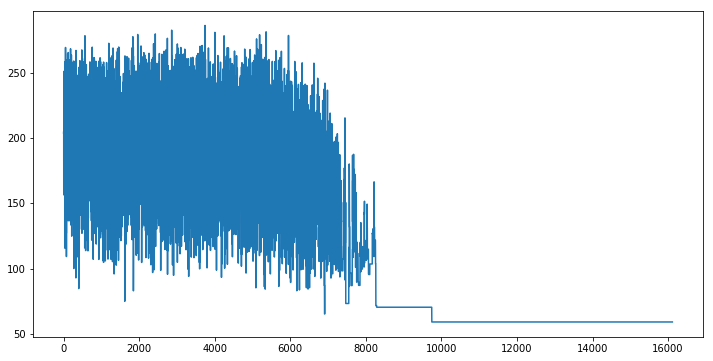

In [7]:
# Plot the change in distance during the simulation
from importlib import reload   # not needed for python 2, added this due to a persisting error..
reload(plt)
plt.figure(figsize=(12,6))
plt.plot(distance.dist_v)

print('Minimized distance: ', '{0:2.3f}'.format(new_distance*69), 'miles.')
print('The route: ', '\n', route)

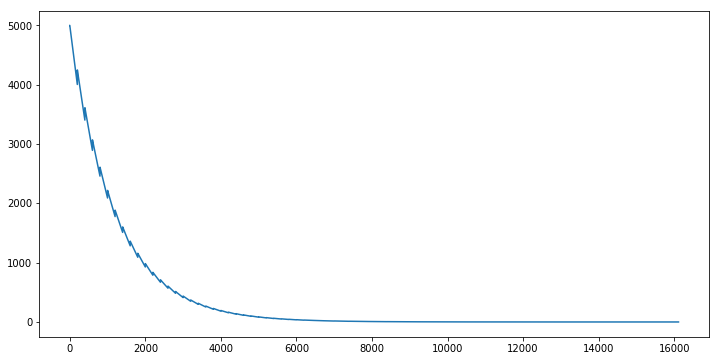

In [8]:
# Plot the change in temperature  during simulation
plt.figure(figsize=(12,6))
plt.plot(distance.tt)

There are multiple challenges in trying to find the minimum distance this way, one major one is the computational time. The correct way to approach solving this is not with an interpreted language, the only way to get manageble calculation times would be to do this in Fortran or C++, which would allow us to use more simulation steps and finish the simulation still in this century. Because of the long computation time and this being just an illustration of the possible MC method to do this minimization, the simulation step number is being kept small and hence the calculated minimum will most likely be a local minima instead of the global minima.